# Bird Call Classifier

## Import Required Libraries

In [40]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## Establish Bird Classes and Create a Label Map

In [41]:
# Initialize bird classes 
bird_classes = sorted(os.listdir("../data/raw/"))
# bird_classes = bird_classes[0:2]

# Initialize a label map for bird classes
label_map = {}

for idx in range(len(bird_classes)):
    bird = bird_classes[idx]
    label_map[bird] = idx

print("BIRD CLASSES:\n", bird_classes, "\n")
print("LABEL MAP:\n", label_map)

BIRD CLASSES:
 ['american_robin', 'bald_eagle', 'northern_cardinal', 'red-tailed_hawk'] 

LABEL MAP:
 {'american_robin': 0, 'bald_eagle': 1, 'northern_cardinal': 2, 'red-tailed_hawk': 3}


## Creating the Dataset and Dataloaders

In [42]:
# Initialize the data direcotry
data_directory = "../data/processed/"

# Initilize lists to hold all spectrograms and labels
all_spectrograms = []
all_labels = []
all_filenames = []

# Loop through each bird class directory and load the spectrograms
for bird in bird_classes:
    bird_directory = os.path.join(data_directory, bird)

    # Loop through each file in the bird directory
    for file_name in os.listdir(bird_directory):

        # Check if the file is a numpy file
        if file_name.endswith(".npy"):
            file_path = os.path.join(bird_directory, file_name)

            # Load the spectrogram
            spectrogram = np.load(file_path)

            # Convert the spectrogram to a tensor
            spectrogram_tensor = torch.tensor(spectrogram).unsqueeze(0).float()

            # Append the spectrogram tensor and label to their respective lists
            all_spectrograms.append(spectrogram_tensor)
            all_labels.append(label_map[bird])
            all_filenames.append(file_name)

# Stack all tensors into a single tensor
x = torch.stack(all_spectrograms)
y = torch.tensor(all_labels)

# Split the dataset into training, validation, and testing sets
x_train, x_temp, y_train, y_temp, file_name_train, file_name_temp = train_test_split(x, y, all_filenames, test_size = 0.2, stratify = y, random_state = 7)

x_val, x_test, y_val, y_test, file_name_val, file_name_test = train_test_split(x_temp, y_temp, file_name_temp, test_size = 0.5, stratify = y_temp, random_state = 7)

# Create the tensor datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [43]:
# Sanity Check for dataset shapes
total_calls = len(all_spectrograms)

print("TRAINING:")
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)
print(f"Percentage: {len(x_train) / total_calls * 100:.2f}\n")

print("VALIDATION:")
print("x shape:", x_val.shape)
print("y shape:", y_val.shape)
print(f"Percentage: {len(x_val) / total_calls * 100:.2f}\n")

print("TESTING:")
print("x shape:", x_test.shape)
print("y shape:", y_test.shape)
print(f"Percentage: {len(x_test) / total_calls * 100:.2f}\n")

TRAINING:
x shape: torch.Size([151, 1, 128, 216])
y shape: torch.Size([151])
Percentage: 79.89

VALIDATION:
x shape: torch.Size([19, 1, 128, 216])
y shape: torch.Size([19])
Percentage: 10.05

TESTING:
x shape: torch.Size([19, 1, 128, 216])
y shape: torch.Size([19])
Percentage: 10.05



## Neural Network Model

In [44]:
class BirdCallCNN(nn.Module):
    def __init__(self, num_classes, conv_layers_config = [(16, 3), (32, 3)], fc_layers = [128], dropout = 0.3):
        super().__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        in_channels = 1

        for out_channels, kernel_size in conv_layers_config:
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, padding = kernel_size // 2))
            self.bns.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)

        self.flattened_size = self._get_flattened_size()

        fc_layers_sizes = [self.flattened_size] + fc_layers
        self.fcs = nn.ModuleList([
            nn.Linear(fc_layers_sizes[i], fc_layers_sizes[i + 1])
            for i in range(len(fc_layers_sizes) - 1)
        ])
        self.output = nn.Linear(fc_layers[-1], num_classes)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 128, 216)
            x = dummy_input
            for conv, bn in zip(self.convs, self.bns):
                x = self.pool(F.relu(bn(conv(x))))
            return x.view(1, -1).size(1)

    def forward(self, x):
        for conv, bn in zip(self.convs, self.bns):
            x = self.pool(F.relu(bn(conv(x))))
            x = self.dropout(x)

        x = x.view(x.size(0), -1)

        for fc in self.fcs:
            x = F.relu(fc(x))
            x = self.dropout(x)

        return self.output(x)


## Training Loop

In [45]:
# Function to train the model
def train_model(model, train_dataloader, val_dataloader, optimizer, device, patience = 5, epochs = 10, print_epochs = False):
    # Establish the loss function
    criterion = nn.CrossEntropyLoss()

    # Establish the optimizer
    if optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
    elif optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

    model.to(device)

    # Lists to store values across epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Early stopping criteria
    best_val_loss = float("inf")
    early_stopping_counter = 0

    # Loop through epochs
    for epoch in range(epochs):
        # ----- TRAINING LOOP -----

        # Set the model to training mode
        model.train()

        # initialize varibles to track loss and accuracy
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Loop through dataloader
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Calculate running training loss and accuracy
        train_loss = running_train_loss / train_total
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # ----- VALIDATION LOOP -----
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate validation loss
                loss = criterion(outputs, labels)

                # Updated running validation loss and accuracy
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = running_val_loss / val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch statistics
        if print_epochs == True:
            print(f"Epoch {epoch + 1}:")
            print(f"\tTraining Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
            print(f"\tValidation Loss: {val_loss:.4f} | Training Accuracy: {val_accuracy:.4f}\n")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

## Hyperparameter Tuning

In [57]:
def tune_hyperparameters(train_loader, val_loader, device, num_classes, params, max_epochs = 15, patience = 5):

    # Initialize varaibles to keep track of best model
    best_model = None
    best_loss = float("inf")
    optimal_parameters = {}

    total_configurations = (len(params["optimizer"]) * 
                            len(params["dropout_rate"]) *
                            len(params["convolutional_layers"]) * 
                            len(params["fully_connected_layers"]))
    
    model_counter = 1

    for optimizer_name in params["optimizer"]:
        for dropout_rate in params["dropout_rate"]:
            for convolutional_config in params["convolutional_layers"]:
                for fully_connected_config in params["fully_connected_layers"]:

                    print(f"\nModel {model_counter}/{total_configurations}: Optimizer: {optimizer_name} | Dropout Rate : {dropout_rate} | Conv Layers: {convolutional_config} | FC Layers: {fully_connected_config}")

                    # Initialize model
                    model = BirdCallCNN(
                        num_classes = num_classes,
                        conv_layers_config = convolutional_config,
                        fc_layers = fully_connected_config,
                        dropout = dropout_rate
                    )

                    # Train model
                    train_losses, train_accs, val_losses, val_accs = train_model(
                        model = model,
                        train_dataloader = train_loader,
                        val_dataloader = val_loader,
                        optimizer = optimizer_name,
                        device = device,
                        patience = patience,
                        epochs = max_epochs,
                        print_epochs = False
                    )

                    final_val_loss = val_losses[-1]
                    print(f"Final Model Validation Loss: {final_val_loss:.4f}")

                    # Save best model/config
                    if final_val_loss < best_loss:
                        best_loss = final_val_loss
                        best_model = model
                        optimal_parameters = {
                            "optimizer": optimizer_name,
                            "dropout_rate": dropout_rate,
                            "convolutional_layers": convolutional_config,
                            "fully_connected_layers": fully_connected_config
                        }

                    model_counter += 1

    print("\nOPTIMAL PARAMETERS:")
    print(f"Optimizer: {optimal_parameters['optimizer']}")
    print(f"Dropout Rate: {optimal_parameters['dropout_rate']}")
    print(f"Convolutional Layers: {optimal_parameters['convolutional_layers']}")
    print(f"Fully Connected Layers: {optimal_parameters['fully_connected_layers']}")

    print(f"\nBest Validation Loss: {best_loss:.4f}")

    # Return the best model and its parameters
    return best_model, optimal_parameters


In [59]:
params = {
    "optimizer": ["adam"],
    "dropout_rate": [0.3, 0.4],
    "convolutional_layers": [[(16, 3), (32, 3)], [(32, 3), (64, 3)], [(16, 5), (32, 5)]],
    "fully_connected_layers": [[128], [256], [128, 64]]
}

best_model, optimal_params = tune_hyperparameters(
    train_loader = train_loader,
    val_loader = val_loader,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_classes = len(bird_classes),
    params = params,
    max_epochs = 10,
    patience = 5
)


Model 1/18: Optimizer: adam | Dropout Rate : 0.3 | Conv Layers: [(16, 3), (32, 3)] | FC Layers: [128]
Early stopping triggered after 10 epochs
Final Model Validation Loss: 1.4735

Model 2/18: Optimizer: adam | Dropout Rate : 0.3 | Conv Layers: [(16, 3), (32, 3)] | FC Layers: [256]
Final Model Validation Loss: 1.8657

Model 3/18: Optimizer: adam | Dropout Rate : 0.3 | Conv Layers: [(16, 3), (32, 3)] | FC Layers: [128, 64]
Final Model Validation Loss: 1.3550

Model 4/18: Optimizer: adam | Dropout Rate : 0.3 | Conv Layers: [(32, 3), (64, 3)] | FC Layers: [128]
Final Model Validation Loss: 1.2873

Model 5/18: Optimizer: adam | Dropout Rate : 0.3 | Conv Layers: [(32, 3), (64, 3)] | FC Layers: [256]
Final Model Validation Loss: 1.6676

Model 6/18: Optimizer: adam | Dropout Rate : 0.3 | Conv Layers: [(32, 3), (64, 3)] | FC Layers: [128, 64]
Final Model Validation Loss: 1.2635

Model 7/18: Optimizer: adam | Dropout Rate : 0.3 | Conv Layers: [(16, 5), (32, 5)] | FC Layers: [128]
Final Model Va

## Save Model

In [60]:
# Set Model Name
model_name = "model_v1.pth"
model_path = os.path.join("../models/", model_name)

# Save the model
torch.save(best_model.state_dict(), model_path)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optimal_params["optimizer"]

train_losses, train_accuracies, val_losses, val_accuracies = train_model(best_model, train_loader, val_loader, optimizer, device, epochs = 50, print_epochs = False)

Early stopping triggered after 13 epochs


## Visualize Training and Validation Losses and Accuracies

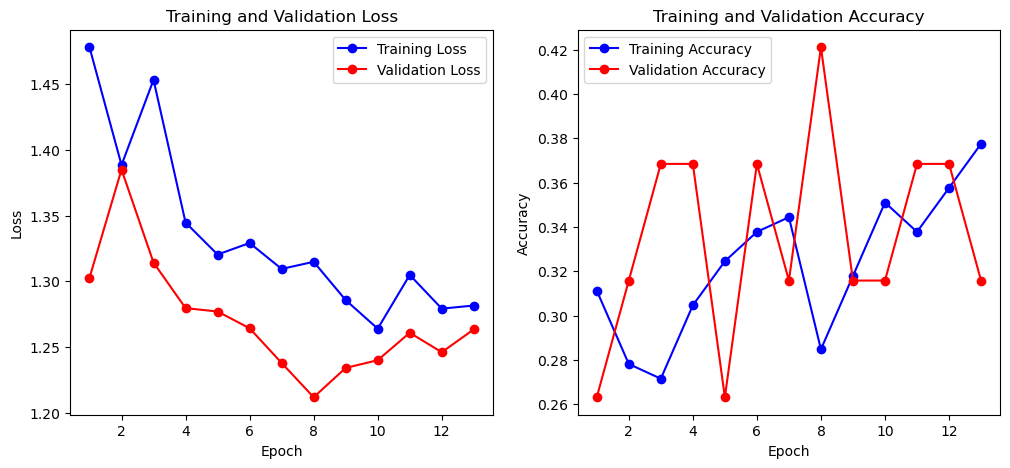

In [63]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize = (12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label = "Training Loss", marker = "o",color = "blue")
    plt.plot(epochs, val_losses, label = "Validation Loss", marker = "o",color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label = "Training Accuracy", marker = "o", color = "blue")
    plt.plot(epochs, val_accuracies, label = "Validation Accuracy", marker = "o",color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()

plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

## Evaluate the Test Set

In [64]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [65]:
all_preds, all_labels = evaluate(best_model, test_loader, device)

In [66]:
predictions_df = pd.DataFrame({
    "Filename": file_name_test,
    "Actual": all_labels,
    "Predicted": all_preds    
})

predictions_df.head(10)

,Filename,Actual,Predicted
0,red-tailed_hawk_30.npy,3,3
1,american_robin_17.npy,0,2
2,bald_eagle_9.npy,1,3
3,red-tailed_hawk_7.npy,3,3
4,bald_eagle_16.npy,1,3
5,american_robin_7.npy,0,3
6,red-tailed_hawk_2.npy,3,3
7,american_robin_12.npy,0,3
8,bald_eagle_1.npy,1,3
9,red-tailed_hawk_43.npy,3,3


## Classification Report and Confusion Matrix

                   precision    recall  f1-score   support

   american_robin       0.00      0.00      0.00         5
       bald_eagle       0.00      0.00      0.00         4
northern_cardinal       0.60      0.60      0.60         5
  red-tailed_hawk       0.36      1.00      0.53         5

         accuracy                           0.42        19
        macro avg       0.24      0.40      0.28        19
     weighted avg       0.25      0.42      0.30        19



c:\Users\DCorc\anaconda3\envs\dsan6600\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DCorc\anaconda3\envs\dsan6600\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DCorc\anaconda3\envs\dsan6600\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

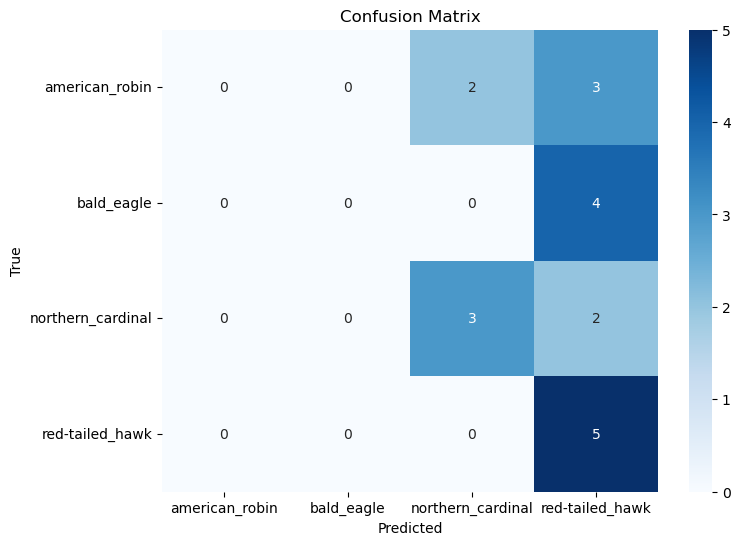

In [67]:
# Print classification report
target_names = list(label_map.keys())
print(classification_report(all_labels, all_preds, target_names = target_names))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", xticklabels = target_names, yticklabels = target_names, cmap = "Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()